**This notebook aims at producing the radial $\kappa$ profiles plot for the Kochanek rebuttal paper (Millon et al. 2019, in prep.)**

_Goal_ : show convergence maps for power-law and composite models with same logarithmic slope and Einstein radius to illustrate flexibility when using power-law and composite mass models. This is to reply CSK's argument which stipulates that H0LiCOW mass models have not enough degrees of freedom, from the observation that kinematics do not give enough constraints on $H_0$.

In [1]:
import copy
import datetime
import time
import tempfile
import corner
import os
import shutil
import scipy
import numpy as np
import matplotlib.pyplot as plt

from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LensModel.lens_model_extensions import LensModelExtensions
from lenstronomy.Sampling.parameters import Param
from lenstronomy.LensModel.Solver.lens_equation_solver import LensEquationSolver
from lenstronomy.Analysis.lens_properties import LensProp
from lenstronomy.Util import util
from lenstronomy.Plots import output_plots

from cosmoHammer import ParticleSwarmOptimizer
from cosmoHammer import CosmoHammerSampler
from cosmoHammer import LikelihoodComputationChain
from cosmoHammer.util import InMemoryStorageUtil
%matplotlib inline

In [2]:
stop_before_optim = False

likelihood_list = ['theta_E_eff', 'time_delays'] # or 'slope_eff'

power_law_type = 'SPEMD'  # or 'SIS'
composite_type = 'HERNQUIST'  # or 'CHAMELEON'
slope_error = 1e-5
theta_E_error = 1e-5
time_delay_errors = [1e-5]

fix_NFW_scale_radius = True
Rs_fixed = 10

run_pso = True
kwargs_pso = {'n_particles': 40, 'n_iterations': 80, 'threads': 8}

run_mcmc = False
kwargs_mcmc = {'walker_ratio': 30, 'n_burn': 60, 'n_run': 60, 'threads': 8}

force_images_at_theta_E = False

# overall fixed parameters
x_source, y_source = 0.1, 0
z_lens, z_source = 0.5, 2

In [3]:
def get_theta_E_eff(lens_model, kwargs_lens):
    model_ext = LensModelExtensions(lens_model)
    return model_ext.effective_einstein_radius(kwargs_lens, verbose=False)

def get_gamma_eff(lens_model, kwargs_lens):
    model_ext = LensModelExtensions(lens_model)
    return model_ext.profile_slope(kwargs_lens, verbose=False)

def get_kappa_on_scaled_grid(xgrid_1d, ygrid_1d, lens_model, kwargs_lens, k=None):
    theta_E = get_theta_E_eff(lens_model, kwargs_lens)
    gamma = get_gamma_eff(lens_model, kwargs_lens)
    print(theta_E, gamma)
    xgrid_1d_scaled = xgrid_1d/theta_E*2
    ygrid_1d_scaled = ygrid_1d/theta_E*2
    kappa = lens_model.kappa(xgrid_1d_scaled, ygrid_1d_scaled, kwargs_lens, k=k)
    return util.array2image(xgrid_1d_scaled), util.array2image(ygrid_1d_scaled), util.array2image(kappa)

def get_alpha_on_scaled_grid(xgrid_1d, ygrid_1d, lens_model, kwargs_lens, k=None):
    theta_E = get_theta_E_eff(lens_model, kwargs_lens)
    gamma = get_gamma_eff(lens_model, kwargs_lens)
    print(theta_E, gamma)
    xgrid_1d_scaled = xgrid_1d/theta_E*2
    ygrid_1d_scaled = ygrid_1d/theta_E*2
    alphax, alphay = lens_model.alpha(xgrid_1d_scaled, ygrid_1d_scaled, kwargs_lens, k=k)
    alpha = np.sqrt(alphax**2 + alphay**2)
    return util.array2image(xgrid_1d_scaled), util.array2image(ygrid_1d_scaled), util.array2image(alpha)

def get_image_positions(lens_model, kwargs_lens, xsource, ysource):
    solver = LensEquationSolver(lens_model)
    ximage, yimage = solver.image_position_from_source(kwargs_lens=kwargs_lens, 
                                                       sourcePos_x=xsource, sourcePos_y=ysource, 
                                                       min_distance=0.01, search_window=5, 
                                                       precision_limit=10**(-10), num_iter_max=100)
    return ximage, yimage

def get_time_delays(lens_model, kwargs_lens, zlens, zsource, xsource=None, ysource=None, kwargsps=None, kappa_ext=0, cosmo=None, return_kwargs_ps=False):
    if (xsource is None or ysource is None) and kwargsps is None:
        raise ValueError
    if kwargsps is None:
        ximage, yimage = get_image_positions(lens_model, kwargs_lens, xsource, ysource)
        kwargsps = [{'ra_image': np.array(ximage), 'dec_image': np.array(yimage)}]
    kwargs_model = {'lens_model_list': lens_model.lens_model_list, 'point_source_model_list': ['LENSED_POSITION']}
    lens_prop = LensProp(zlens, zsource, kwargs_model, cosmo=cosmo)
    travel_times = lens_prop.time_delays(kwargs_lens, kwargsps, kappa_ext=kappa_ext)
    tds = travel_times[0] - travel_times[1:]
    if return_kwargs_ps:
        return tds, kwargsps
    return tds

def get_vel_disp(kwargs_lens, r_eff):
    pass

def plot_slice_1d(ax, xgrid_2d, map_2d, scale='lin', **kwargs):
    nx, ny = map_2d.shape
    half = int(ny/2)
    if scale == 'lin':
        ax.plot(xgrid_2d[half, :], map_2d[half, :], **kwargs)
    elif scale == 'log':
        ax.loglog(xgrid_2d[half, :], map_2d[half, :], **kwargs)
    return ax

In [4]:
# create pixel grid
num_pix = 400
delta_pix = 0.02
x_grid_1d, y_grid_1d = util.make_grid(num_pix, delta_pix)
x_grid_2d = util.array2image(x_grid_1d)
y_grid_2d = util.array2image(y_grid_1d)
print(x_grid_1d)
extent = [-num_pix/2*delta_pix, num_pix/2*delta_pix, -num_pix/2*delta_pix, num_pix/2*delta_pix]

[-3.99 -3.97 -3.95 ...  3.95  3.97  3.99]


In [5]:
### POWER-LAW MODEL ###
if power_law_type == 'SPEMD':
    ModelPowerlaw = LensModel(['SPEMD'])
    kwargs_lens_powerlaw = [{'gamma': 2, 'theta_E': 2, 'center_x': 0, 'center_y': 0, 'e1': 0, 'e2': 0}]
elif power_law_type == 'SIS':
    ModelPowerlaw = LensModel(['SIS'])
    kwargs_lens_powerlaw = [{'theta_E': 1, 'center_x': 0, 'center_y': 0}]
x_grid_2d_powerlaw, y_grid_2d_powerlaw, kappa_powerlaw \
    = get_kappa_on_scaled_grid(x_grid_1d, y_grid_1d, ModelPowerlaw, kwargs_lens_powerlaw)


### COMPOSITE MODEL ###
kwargs_lens_composite = [{'Rs': 10, 'alpha_Rs': 1, 'e1': 0, 'e2': 0, 'center_x': 0, 'center_y': 0}]
if composite_type == 'CHAMELEON':
    ModelComposite = LensModel(['NFW_ELLIPSE', 'CHAMELEON'])
    kwargs_lens_composite.append({'alpha_1': 1, 'w_c': 0.01, 'w_t': 30, 'e1': 0, 'e2': 0, 'center_x': 0, 'center_y': 0})
elif composite_type == 'HERNQUIST':
    ModelComposite = LensModel(['NFW_ELLIPSE', 'HERNQUIST'])
    kwargs_lens_composite.append({'sigma0': 1, 'Rs': 0.8, 'center_x': 0, 'center_y': 0})
x_grid_2d_composite, y_grid_2d_composite, kappa_composite \
    = get_kappa_on_scaled_grid(x_grid_1d, y_grid_1d, ModelComposite, kwargs_lens_composite)

_, _, kappa_dm_only = get_kappa_on_scaled_grid(x_grid_1d, y_grid_1d, ModelComposite, kwargs_lens_composite, k=0)
_, _, kappa_baryon_only = get_kappa_on_scaled_grid(x_grid_1d, y_grid_1d, ModelComposite, kwargs_lens_composite, k=1)


1.9870472472472474 1.9999498001766376
0.9059877877877879 1.877471898600099
0.9059877877877879 1.877471898600099
0.9059877877877879 1.877471898600099


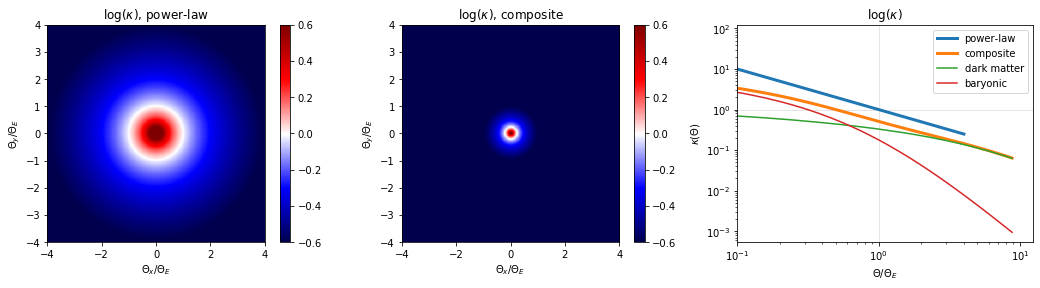

In [6]:
fig, axes = plt.subplots(1, 3, figsize=(18, 4))

ax = axes[0]
ax.set_title("log($\kappa$), power-law")
im = ax.imshow(np.log10(kappa_powerlaw), origin='lower', extent=extent, cmap='seismic', vmin=-0.6, vmax=0.6)
ax.set_xlabel("$\Theta_x / \Theta_E$")
ax.set_ylabel("$\Theta_y / \Theta_E$")
plt.colorbar(im, ax=ax)

ax = axes[1]
ax.set_title("log($\kappa$), composite")
im = ax.imshow(np.log10(kappa_composite), origin='lower', extent=extent, cmap='seismic', vmin=-0.6, vmax=0.6)
ax.set_xlabel('$\Theta_x / \Theta_E$')
ax.set_ylabel('$\Theta_y / \Theta_E$')
plt.colorbar(im, ax=ax)

ax = axes[2]
ax.set_title("log($\kappa$)")
#r_range = np.linspace(0, num_pix/2*delta_pix, 50)
#slope_plot = kwargs_lens_powerlaw[0]['gamma'] - 1
#ax.loglog(r_range, 2*r_range**(-slope_plot), linestyle=':', color='black', label='slope $\gamma-1$')
ax.axvline(1, linewidth=1, color='black', alpha=0.1)
ax.axhline(1, linewidth=1, color='black', alpha=0.1)
plot_slice_1d(ax, x_grid_2d_powerlaw, kappa_powerlaw, scale='log', linewidth=3, label='power-law')
plot_slice_1d(ax, x_grid_2d_composite, kappa_composite, scale='log', linewidth=3, label='composite')
plot_slice_1d(ax, x_grid_2d_composite, kappa_dm_only, scale='log', label='dark matter')
plot_slice_1d(ax, x_grid_2d_composite, kappa_baryon_only, scale='log', label='baryonic')
ax.set_xlim(left=1e-1)
ax.set_xlabel('$\Theta / \Theta_E$')
ax.set_ylabel('$\kappa(\Theta)$')
ax.legend()

plt.show()

In [7]:
### TIME DELAYS ###
if not force_images_at_theta_E:
    time_delays_powerlaw, kwargs_ps_powerlaw = get_time_delays(ModelPowerlaw, kwargs_lens_powerlaw, z_lens, z_source, x_source, y_source, return_kwargs_ps=True)
else:
    r_ps = kwargs_lens_powerlaw[0]['theta_E'] / 2.
    kwargs_ps_powerlaw = [{'ra_image': np.array([r_ps]*2), 'dec_image': np.array([r_ps]*2)}]
    time_delays_powerlaw = get_time_delays(ModelPowerlaw, kwargs_lens_powerlaw, z_lens, z_source, kwargsps=kwargs_ps_powerlaw)

time_delays_composite = get_time_delays(ModelComposite, kwargs_lens_composite, z_lens, z_source, kwargsps=kwargs_ps_powerlaw)
print(time_delays_powerlaw)
print(time_delays_composite)

[-34.3841394]
[-15.17211379]


## Make the final plot for Millon et al. 2019

TD : Power-law vs Composite : [-34.43164127] vs [-34.3841394]
2.0020619619619624 1.9999999964629458
2.0020619619619624 1.9999999964629458
2.0020619619619624 1.9999999964629458


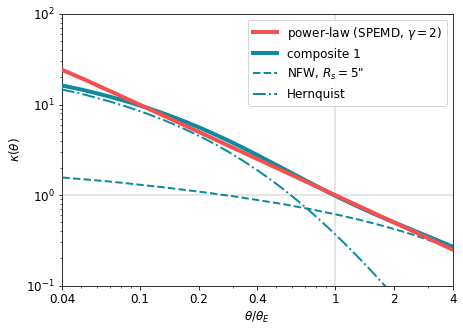

In [8]:
# TODO : Rs should be expressed in theta_E units for consistency with labels

# choice of final set of parameters
kwargs_final_list = [
    #[
    #    {'Rs': 5, 'alpha_Rs': 1.591666222563099, 'e1': 0, 'e2': 0, 'center_x': 0, 'center_y': 0}, 
    #     {'sigma0': 3.131305316734818, 'Rs': 0.5798832544569414, 'center_x': 0, 'center_y': 0}
    #],
    [
        {'Rs': 10, 'alpha_Rs': 1.859798350051849, 'e1': 0, 'e2': 0, 'center_x': 0, 'center_y': 0}, 
        {'sigma0': 3.9553284167172613, 'Rs': 0.5744157735500814, 'center_x': 0, 'center_y': 0}
    ],
    #[
    #    {'Rs': 44.23770976420644, 'alpha_Rs': 2.8465289048470557, 'e1': 0, 'e2': 0, 'center_x': 0, 'center_y': 0}, 
    #     {'sigma0': 1.6830590770482168, 'Rs': 1.31570394828319, 'center_x': 0, 'center_y': 0}
    #],
]
color_list = ['#0d8a9c', '#18b5cc']
extra_info_list = [r', $R_{s}=5$"', r', $R_{s}=10$"', r', $R_{s,\,\rm{NFW}}$ free']


###


#import matplotlib as mpl
#mpl.rc('font', family='sans-serif')

fontsize = 16
fontsize_small = 14
fontsize_large = 18
color_power_law = '#f64f4f' #'#0074bf'
#color_composite = '#f29a1a'

fig_final, axes = plt.subplots(1, 1, figsize=(7, 5))
ax = axes
r_range = np.linspace(0, num_pix/2*delta_pix, 50)
ax.axvline(1, linewidth=2, color='black', alpha=0.1)  # Einstein radius location
ax.axhline(1, linewidth=2, color='black', alpha=0.1)  # Einstein radius location

# power-law
plot_slice_1d(ax, x_grid_2d_powerlaw, kappa_powerlaw, scale='log', color=color_power_law, linewidth=4, zorder=10, label='power-law (SPEMD, $\gamma=2$)')

# slope for indication
#r_range = np.linspace(0.08, 0.2, 10)
#ax.loglog(r_range, 3*r_range**(-slope_plot), linewidth=3, linestyle=':', color='black', label='$\gamma-1$')

for i, kwargs_lens_final in enumerate(kwargs_final_list):
    
    # test : get time delays
    td = get_time_delays(ModelComposite, kwargs_lens_final, z_lens, z_source, kwargsps=kwargs_ps_powerlaw)
    print(r"TD : Power-law vs Composite : {} vs {}".format(td, time_delays_powerlaw))
    #print("kinem : Power-law vs Composite : {} vs {}".format(td, time_delays_powerlaw))
    
    # retrieve scaled kappa maps
    x_grid_2d_composite, y_grid_2d_composite, kappa_result_composite \
        = get_kappa_on_scaled_grid(x_grid_1d, y_grid_1d, ModelComposite, kwargs_lens_final)
    _, _, kappa_result_dm_only \
        = get_kappa_on_scaled_grid(x_grid_1d, y_grid_1d, ModelComposite, kwargs_lens_final, k=0)
    _, _, kappa_result_baryon_only \
        = get_kappa_on_scaled_grid(x_grid_1d, y_grid_1d, ModelComposite, kwargs_lens_final, k=1)

    # composite and separated components
    plot_slice_1d(ax, x_grid_2d_composite, kappa_result_composite, scale='log', color=color_list[i], linewidth=4, zorder=7, label='composite ' + str(i+1))
    plot_slice_1d(ax, x_grid_2d_composite, kappa_result_dm_only, scale='log', color=color_list[i], linewidth=2, linestyle='--', zorder=6, label='NFW'+extra_info_list[i])
    plot_slice_1d(ax, x_grid_2d_composite, kappa_result_baryon_only, scale='log', color=color_list[i], linewidth=2, linestyle='-.', zorder=5, label='Hernquist')

ax.set_xlim(4e-2, 4e0)
ax.set_ylim(1e-1, 1e2)
ax.set_xlabel(r"$\theta / \theta_E$", fontsize=fontsize_large)
ax.set_ylabel(r"$\kappa(\theta)$", fontsize=fontsize_large)
ax.set_xticks([0.04, 0.1, 0.2, 0.4, 1, 2, 4])
ax.set_xticklabels([0.04, 0.1, 0.2, 0.4, 1, 2, 4], fontsize=fontsize)
ax.tick_params(axis='y', labelsize=fontsize)
#ax.legend(bbox_to_anchor=(1.04, 1), loc='upper left', fontsize=fontsize)
ax.legend(loc='upper right', fontsize=fontsize_small)
plt.show()

fig_final.savefig("lens_models.pdf")

In [9]:
if stop_before_optim:
    raise RuntimeError

In [10]:
class LensSlopeLikelihood(object):
    """Defines the likelihod to maximize to constrain the lens model slope and Einstein radius"""
    
    def __init__(self, likelihood_list, lens_model_list, check_bounds=True, verbose=False,
                 theta_E_value=1, theta_E_error=0.01, slope_value=2, slope_error=0.01, 
                 time_delay_values=[1], time_delay_errors=[1], z_source=None, z_lens=None, kwargs_ps=None,
                 kwargs_lens_init=None, kwargs_fixed_lens=None, kwargs_lower_lens=None, kwargs_upper_lens=None, 
                 kwargs_sigma_lens=None):
        self.likelihood_list = likelihood_list
        self.lens_model = LensModel(lens_model_list)
        self.kwargs_model = {'lens_model_list': lens_model_list}
        self.param = Param(self.kwargs_model, kwargs_lens_init=kwargs_lens_init, 
                           kwargs_fixed_lens=kwargs_fixed_lens, 
                           kwargs_lower_lens=kwargs_lower_lens, kwargs_upper_lens=kwargs_upper_lens)
        self.lower_limit, self.upper_limit = self.param.param_limits()
        if kwargs_lens_init is not None:
            self.init_position = self.kwargs2args(kwargs_lens_init)
        else:
            self.init_position = [{}] * len(lens_model_list)
        self.sampling_sigma = self.kwargs2args(kwargs_sigma_lens)
        
        self._check_bounds  = check_bounds
        
        self._theta_E_value = theta_E_value
        self._theta_E_error = theta_E_error
        self._slope_value   = slope_value
        self._slope_error   = slope_error
        self._time_delay_values = time_delay_values
        self._time_delay_errors = time_delay_errors
            
        self._z_lens = z_lens
        self._z_source = z_source
        self._kwargs_ps = kwargs_ps
        
        self._verbose = verbose
    
    def __call__(self, args):
        return self.logL(args)
    
    def setup(self):
        "for CosmoHammer MCMC sampler"
        pass
    
    def computeLikelihood(self, ctx):
        "for CosmoHammer MCMC sampler"
        logL, _ = self.logL(ctx.getParams())
        return logL
        
    def logL(self, args):
        if self._check_bounds:
            inside_bounds = self.check_bounds(args)
            if not inside_bounds:
                return -1e15, None
        kwargs_all = self.args2kwargs(args)
        return self.log_likelihood(kwargs_all)
    
    def log_likelihood(self, kwargs_all):
        logL = 0
        for ll_type in self.likelihood_list:
            if ll_type == 'theta_E_eff':
                logL += self.theta_E_log_likelihood(kwargs_all['kwargs_lens'])
            elif ll_type == 'slope_eff':
                logL += self.slope_log_likelihood(kwargs_all['kwargs_lens'])
            elif ll_type == 'time_delays':
                logL += self.slope_log_likelihood(kwargs_all['kwargs_lens'])
            elif ll_type == 'vel_disp':
                # TODO
                continue
        return logL, None
    
    def slope_log_likelihood(self, kwargs_lens):
        slope_model = self.effective_slope(kwargs_lens)
        if not np.isfinite(slope_model):
            return -1e15
        chi2 = (slope_model - self._slope_value)**2 / self._slope_error**2 / 2
        return -chi2
    
    def theta_E_log_likelihood(self, kwargs_lens):
        theta_E_model = self.effective_einstein_radius(kwargs_lens)
        if not np.isfinite(theta_E_model):
            return -1e15
        chi2 = (theta_E_model - self._theta_E_value)**2 / self._theta_E_error**2 / 2
        return -chi2
    
    def time_delays_log_likelihood(self, kwargs_lens):
        time_delays_model = self.time_delays(kwargs_lens)
        if not np.all(np.isfinite(time_delays_model)):
            return -1e15
        chi2 = np.sum((time_delays_model - self._time_delay_values)**2 / self._time_delay_errors**2 / 2)
        return -chi2
    
    def check_bounds(self, args):
        for i in range(len(args)):
            if not (self.lower_limit[i] < args[i] < self.upper_limit[i]):
                if self._verbose:
                    print("parameter {} with value {} hits the bounds [{}, {}] "
                          .format(i, args[i], self.lower_limit[i], self.upper_limit[i]))
                return False
        return True
    
    def effective_einstein_radius(self, kwargs_lens):
        return get_theta_E_eff(self.lens_model, kwargs_lens)
        
    def effective_slope(self, kwargs_lens):
        return get_gamma_eff(self.lens_model, kwargs_lens)
    
    def time_delays(self, kwargs_lens):
        return get_time_delays(self.lens_model, kwargs_lens, self._z_lens, self._z_source, kwargsps=self._kwargs_ps)
    
    def args2kwargs(self, args):
        return self.param.args2kwargs(args)
    
    def kwargs2args(self, kwargs):
        return self.param.kwargs2args(kwargs_lens=kwargs)
    
    @property
    def num_param_all(self):
        #TODO
        return None
    
    @property
    def num_param_eff(self):
        return self.param.num_param()[0]
    
    @property
    def param_names(self):
        return self.param.num_param()[1]

    
class Optimizer(object):
    """Simplified version from the lenstronomy optimizer"""
    
    def __init__(self, likelihood):
        self._chain = likelihood
        self._init_pos = likelihood.init_position
        self._lower_limit, self._upper_limit = likelihood.lower_limit, likelihood.upper_limit
        print("Effective number of data points to be sampled :", likelihood.num_param_eff)
        
    def least_squares(self):
        """Optimize using the least_squares() method from SciPy"""
        fun = lambda x: self._chain(x)[0]
        x0 = np.array(self._init_pos)
        print('Solving the non-linear least squares problem...')
        time_start = time.time()
        optimize_result = scipy.optimize.least_squares(fun, x0)
        time_end = time.time()
        print("Time used for least-squares :", time_end - time_start)
        result = optimize_result.x
        logL = optimize_result.fun
        cost = optimize_result.cost
        kwargs_result = self._chain.param.args2kwargs(result)
        return kwargs_result, logL, cost
    
    def pso(self, n_particles=10, n_iterations=10, threads=1, start_in_middle=False):
        """Optimize using the Particle Swarm Optimizer from CosmoHammer"""
        lower_start = np.array(self._lower_limit)
        upper_start = np.array(self._upper_limit)
        if start_in_middle:
            init_pos = (upper_start - lower_start) / 2 + lower_start
        else:
            init_pos = self._init_pos
        
        pso = ParticleSwarmOptimizer(self._chain, lower_start, upper_start, n_particles, threads=threads)
        pso.gbest.position = init_pos
        pso.gbest.velocity = [0] * len(init_pos)
        pso.gbest.fitness, _ = self._chain(init_pos)
        
        X2_list = []
        vel_list = []
        pos_list = []
        
        time_start = time.time()
        print('Computing the PSO ...')
        num_iter = 0
        for swarm in pso.sample(n_iterations):
            X2_list.append(pso.gbest.fitness*2)
            vel_list.append(pso.gbest.velocity)
            pos_list.append(pso.gbest.position)
            num_iter += 1
            if num_iter % 10 == 0:
                print(num_iter)
        time_end = time.time()
        
        result = pso.gbest.position
        kwargs_result = self._chain.param.args2kwargs(result)
        
        print('===================')
        print("logL =", pso.gbest.fitness)
        print("Reduced X^2 of best position :", pso.gbest.fitness * 2 / (max(self._chain.num_param_eff, 1)))
        print("Effective number of data points :", self._chain.num_param_eff)
        print(kwargs_result.get('kwargs_lens', None), 'lens result')
        print("Time used for PSO :", time_end - time_start)
        print('===================')
        
        chain = [X2_list, pos_list, vel_list, []]
        param_names = self._chain.param_names
        return kwargs_result, chain, param_names

    
class Sampler(object):
    """Simplified version from the lenstronomy sampler"""
    
    def __init__(self, likelihood):
        self._chain = likelihood
        self._init_pos = likelihood.init_position
        self._lower_limit, self._upper_limit = likelihood.lower_limit, likelihood.upper_limit
        print("Effective number of data points to be sampled :", likelihood.num_param_eff)
    
    def mcmc(self, walker_ratio=10, n_burn=10, n_run=10, threads=1, kwargs_start=None):
        """Sample using the MCMC algorithm from CosmoHammer"""
        if kwargs_start is None:
            mean_start = self._chain.init_position
        else:
            mean_start = self._chain.kwargs2args(kwargs_start['kwargs_lens'])
            
        sigma_start = self._chain.sampling_sigma
        
        lower_limit, upper_limit = self._lower_limit, self._upper_limit
        mean_start = np.maximum(lower_limit, mean_start)
        mean_start = np.minimum(upper_limit, mean_start)

        low_start = mean_start - sigma_start
        high_start = mean_start + sigma_start
        low_start = np.maximum(lower_limit, low_start)
        high_start = np.minimum(upper_limit, high_start)
        sigma_start = (high_start - low_start) / 2
        mean_start = (high_start + low_start) / 2
        params = np.array([mean_start, lower_limit, upper_limit, sigma_start]).T

        chain = LikelihoodComputationChain(min=lower_limit, max=upper_limit)

        temp_dir = tempfile.mkdtemp("Hammer")
        file_prefix = os.path.join(temp_dir, "logs")
        chain.addLikelihoodModule(self._chain)
        chain.setup()

        store = InMemoryStorageUtil()
        sampler = CosmoHammerSampler(
            params=params,
            likelihoodComputationChain=chain,
            filePrefix=file_prefix,
            walkersRatio=walker_ratio,
            burninIterations=n_burn,
            sampleIterations=n_run,
            threadCount=threads,
            initPositionGenerator=None,
            storageUtil=store)
        
        time_start = time.time()
        print('Computing the MCMC...')
        sampler.startSampling()
        time_end = time.time()
        print('===================')
        print('Number of walkers :', len(mean_start)*walker_ratio)
        print('Burn-in iterations :', n_burn)
        print('Sampling iterations :', n_run)
        print("Time taken for MCMC sampling :", time_end - time_start)
        print('===================')
        try:
            shutil.rmtree(temp_dir)
        except Exception as ex:
            print(ex, 'shutil.rmtree did not work')
            pass
        param_names = self._chain.param_names
        return store.samples, store.prob, param_names
        

In [11]:
kwargs_init = copy.deepcopy(kwargs_lens_composite)

kwargs_fixed = [{'e1': 0, 'e2': 0, 'center_x': 0, 'center_y': 0}]
if fix_NFW_scale_radius:
    kwargs_fixed[0]['Rs'] = Rs_fixed
    
if composite_type == 'CHAMELEON':
    kwargs_fixed.append({'e1': 0, 'e2': 0, 'center_x': 0, 'center_y': 0})
elif composite_type == 'HERNQUIST':
    kwargs_fixed.append({'center_x': 0, 'center_y': 0})

kwargs_sigma = [{'Rs': 0.1, 'alpha_Rs': 0.1, 'e1': 0.05, 'e2': 0.05, 'center_x': 0.01, 'center_y': 0.01}]
if composite_type == 'CHAMELEON':
    kwargs_sigma.append({'alpha_1': 0.1, 'w_c': 0.1, 'w_t': 0.1, 'e1': 0.05, 'e2': 0.05, 'center_x': 0.01, 'center_y': 0.01})
elif composite_type == 'HERNQUIST':
    kwargs_sigma.append({'sigma0': 0.1, 'Rs': 0.1, 'center_x': 0.01, 'center_y': 0.01})

kwargs_lower = [{'Rs': 0, 'alpha_Rs': 0, 'e1': -0.5, 'e2': -0.5, 'center_x': -0.1, 'center_y': -0.1}]
if composite_type == 'CHAMELEON':
    kwargs_lower.append({'alpha_1': 0, 'w_c': 0, 'w_t': 0, 'e1': -0.5, 'e2': -0.5, 'center_x': -0.1, 'center_y': -0.1})
elif composite_type == 'HERNQUIST':
    kwargs_lower.append({'sigma0': 0, 'Rs': 0, 'center_x': -0.1, 'center_y': -0.1})
    
kwargs_upper = [{'Rs': 60, 'alpha_Rs': 10, 'e1': 0.5, 'e2': 0.5, 'center_x': 0.1, 'center_y': 0.1}]
if composite_type == 'CHAMELEON':
    kwargs_upper.append({'alpha_1': 10, 'w_c': 20, 'w_t': 20, 'e1': 0.5, 'e2': 0.5, 'center_x': 0.1, 'center_y': 0.1})
elif composite_type == 'HERNQUIST':
    kwargs_upper.append({'sigma0': 20, 'Rs': 20, 'center_x': 0.1, 'center_y': 0.1})

slope_value = kwargs_lens_powerlaw[0]['gamma']
theta_E_value = kwargs_lens_powerlaw[0]['theta_E']
time_delay_values = time_delays_powerlaw

likelihood_class = LensSlopeLikelihood(likelihood_list, ModelComposite.lens_model_list,
                                       theta_E_value=theta_E_value, theta_E_error=theta_E_error, 
                                       slope_value=slope_value, slope_error=slope_error, 
                                       time_delay_values=time_delay_values, time_delay_errors=time_delay_errors,
                                       kwargs_lens_init=kwargs_init, kwargs_fixed_lens=kwargs_fixed, 
                                       kwargs_lower_lens=kwargs_lower, kwargs_upper_lens=kwargs_upper,
                                       kwargs_sigma_lens=kwargs_sigma, z_lens=z_lens, z_source=z_source, 
                                       kwargs_ps=kwargs_ps_powerlaw, check_bounds=True, verbose=False)
#print(likelihood_class.kwargs2args(kwargs_lens_nfw_cham))
#print(likelihood_class.args2kwargs(likelihood_class.kwargs2args(kwargs_lens_nfw_cham)))

print(kwargs_init)
print("theta_E_eff =", likelihood_class.effective_einstein_radius(kwargs_init))
print("gamma_eff =", likelihood_class.effective_slope(kwargs_init))

[{'Rs': 10, 'alpha_Rs': 1, 'e1': 0, 'e2': 0, 'center_x': 0, 'center_y': 0}, {'sigma0': 1, 'Rs': 0.8, 'center_x': 0, 'center_y': 0}]
theta_E_eff = 0.9059877877877879
gamma_eff = 1.877471898600099


In [12]:
optimizer_class = Optimizer(likelihood_class)
if run_pso:
    chain_list = []
    kwargs_result, chain, param_names = optimizer_class.pso(**kwargs_pso)
    chain_list.append(['PSO', chain, param_names])
else:
    kwargs_result, logL, cost = optimizer_class.least_squares()
    print("LS : logL = {}, cost = {}".format(logL, cost))

Effective number of data points to be sampled : 3
Computing the PSO ...
10
20
30
40
50
60
70
80
90
100
max iteration reached! stoping
logL = -21258.43803678702
Reduced X^2 of best position : -14172.29202452468
Effective number of data points : 3
[{'Rs': 10, 'alpha_Rs': 1.8003255970119347, 'e1': 0, 'e2': 0, 'center_x': 0, 'center_y': 0}, {'sigma0': 3.169975476620315, 'Rs': 0.6756072478634052, 'center_x': 0, 'center_y': 0}] lens result
Time used for PSO : 380.4295070171356


{'kwargs_lens': [{'Rs': 10, 'alpha_Rs': 1.8003255970119347, 'e1': 0, 'e2': 0, 'center_x': 0, 'center_y': 0}, {'sigma0': 3.169975476620315, 'Rs': 0.6756072478634052, 'center_x': 0, 'center_y': 0}], 'kwargs_source': [], 'kwargs_lens_light': [], 'kwargs_ps': [], 'kwargs_special': {}, 'kwargs_extinction': []}
Resulting effective slope : 1.9999993109589445
Resulting effective Einstein radius : 2.0020619619619624


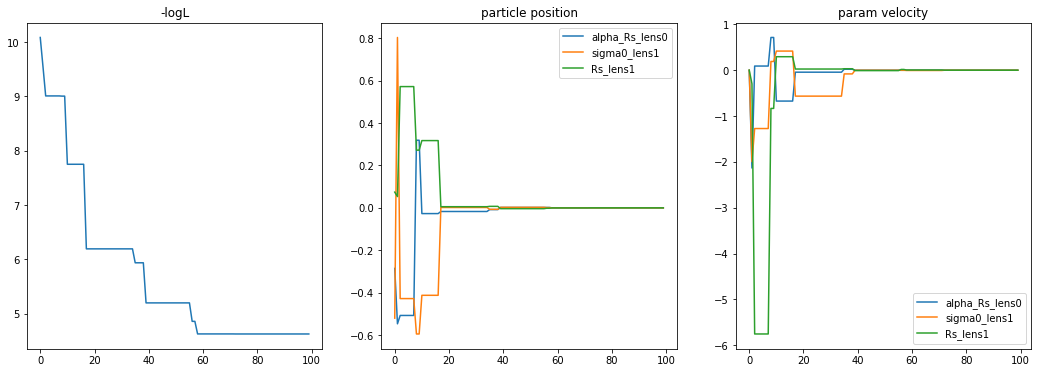

<Figure size 432x288 with 0 Axes>

In [13]:
print(kwargs_result)
print("Resulting effective slope :", get_gamma_eff(ModelComposite, kwargs_result['kwargs_lens']))
print("Resulting effective Einstein radius :", get_theta_E_eff(ModelComposite, kwargs_result['kwargs_lens']))
if run_pso:
    output_plots.plot_chain_list(chain_list, index=-1)
    plt.show()

### Run MCMC for posteriors visualization

In [14]:
# run MCMC
if run_mcmc:
    sampler_class = Sampler(likelihood_class)
    samples, logL_chain, param_names = sampler_class.mcmc(kwargs_start=kwargs_result, **kwargs_mcmc)
    chain_list.append(['COSMOHAMMER', samples, param_names, logL_chain])
    
    fig_corner = corner.corner(samples, labels=param_names, show_titles=True)
    plt.show()

In [15]:
if run_mcmc:
    output_plots.plot_chain_list(chain_list, index=-1)
    plt.show()

In [16]:
if composite_type == 'CHAMELEON':
    w_c = kwargs_result['kwargs_lens'][1].get('w_c', 0)
    w_t = kwargs_result['kwargs_lens'][1].get('w_t', 1000)
    if w_t < w_c:
        # switch w_t and w_c when sampling messed up with these parameters
        w_c, w_t = w_t, w_c
        kwargs_result['kwargs_lens'][1]['w_c'] = w_c
        kwargs_result['kwargs_lens'][1]['w_t'] = w_t

### Take a look at convergence maps and resulting radial profiles

2.0020619619619624 1.9999993109589445
2.0020619619619624 1.9999993109589445
2.0020619619619624 1.9999993109589445
TD Composite : [-34.45569745] vs [-34.3841394]


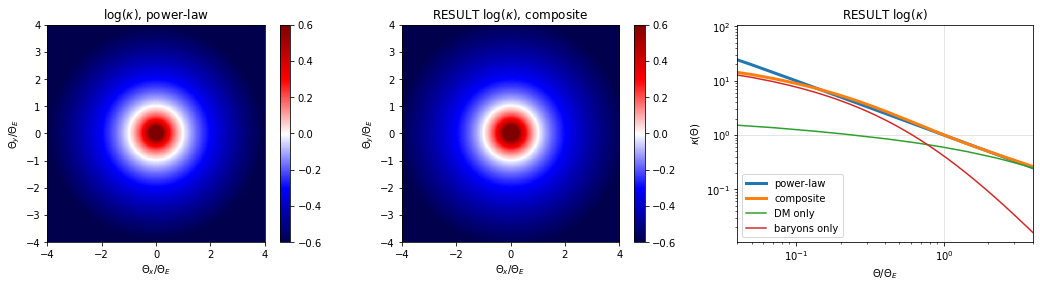

In [17]:
# retrieve scaled kappa maps
x_grid_2d_composite, y_grid_2d_composite, kappa_result_composite \
    = get_kappa_on_scaled_grid(x_grid_1d, y_grid_1d, ModelComposite, kwargs_result['kwargs_lens'])
_, _, kappa_result_dm_only \
    = get_kappa_on_scaled_grid(x_grid_1d, y_grid_1d, ModelComposite, kwargs_result['kwargs_lens'], k=0)
_, _, kappa_result_baryon_only \
    = get_kappa_on_scaled_grid(x_grid_1d, y_grid_1d, ModelComposite, kwargs_result['kwargs_lens'], k=1)

td = get_time_delays(ModelComposite, kwargs_result['kwargs_lens'], z_lens, z_source, kwargsps=kwargs_ps_powerlaw)
print("TD Composite : {} vs {}".format(td, time_delays_powerlaw))

# plot results
fig, axes = plt.subplots(1, 3, figsize=(18, 4))

ax = axes[0]
ax.set_title("log($\kappa$), power-law")
im = ax.imshow(np.log10(kappa_powerlaw), origin='lower', extent=extent, cmap='seismic', vmin=-0.6, vmax=0.6)
ax.set_xlabel("$\Theta_x / \Theta_E$")
ax.set_ylabel("$\Theta_y / \Theta_E$")
plt.colorbar(im, ax=ax)

ax = axes[1]
ax.set_title("RESULT log($\kappa$), composite")
im = ax.imshow(np.log10(kappa_result_composite), origin='lower', extent=extent, cmap='seismic', vmin=-0.6, vmax=0.6)
ax.set_xlabel("$\Theta_x / \Theta_E$")
ax.set_ylabel("$\Theta_y / \Theta_E$")
plt.colorbar(im, ax=ax)

ax = axes[2]
ax.set_title("RESULT log($\kappa$)")
#r_range = np.linspace(0, num_pix/2*delta_pix, 50)
#ax.loglog(r_range, r_range**(-slope_plot), linestyle=':', color='black')
ax.axvline(1, linewidth=1, color='black', alpha=0.1)  # Einstein radius location
ax.axhline(1, linewidth=1, color='black', alpha=0.1)  # Einstein radius location
plot_slice_1d(ax, x_grid_2d_powerlaw, kappa_powerlaw, scale='log', linewidth=3, label='power-law')
plot_slice_1d(ax, x_grid_2d_composite, kappa_result_composite, scale='log', linewidth=3, label='composite')
plot_slice_1d(ax, x_grid_2d_composite, kappa_result_dm_only, scale='log', label='DM only')
plot_slice_1d(ax, x_grid_2d_composite, kappa_result_baryon_only, scale='log', label='baryons only')
ax.set_xlim(4e-2, 4e0)
ax.set_xlabel("$\Theta / \Theta_E$")
ax.set_ylabel("$\kappa(\Theta)$")
ax.legend()

### Write in a file optimized parameters

In [18]:
result_file = "composite_optimized.txt"
if not os.path.exists(result_file):
    open_type = 'w'
else:
    open_type = 'a'
with open(result_file, open_type) as f:
    f.write("="*20+'\n')
    f.write("day-hour : {}\n".format(datetime.datetime.now().strftime('%y%m%d-%H%M%S')))
    f.write("kappa_scaling : {}\n".format(kwargs_pso))
    f.write("kwargs_pso : {}\n".format(kwargs_pso))
    f.write("kwargs_lens (PSO best-fit) : {}\n".format(kwargs_result['kwargs_lens']))
    f.write("num_pix = {}, delta_pix = {}\n".format(num_pix, delta_pix))
    f.write("slope_error = {}, theta_E_error = {}\n".format(slope_error, theta_E_error))
    f.write("="*20+'\n')